## Clustering Top 10 and Bottom 10 countries (2005-2014) 

This is for confirming their position when using average USD_CAP to rank. We are first filtering the original dataset to the years 2005-2014 where the data is most complete for most countries.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Loading the dataset and dropping FLAG_CODES
df = pd.read_csv('Pharmaceutical Drug Spending by countries.csv')
df = df.drop_duplicates()
df = df.drop(columns="FLAG_CODES")
df

LOCATION  TIME  PC_HEALTHXP  PC_GDP   USD_CAP  TOTAL_SPEND
0         AUS  1971       15.992   0.727    35.720       462.11
1         AUS  1972       15.091   0.686    36.056       475.11
2         AUS  1973       15.117   0.681    39.871       533.47
3         AUS  1974       14.771   0.755    47.559       652.65
4         AUS  1975       11.849   0.682    47.561       660.76
...       ...   ...          ...     ...       ...          ...
1031      USA  2011       11.855   1.939   965.580    300935.91
1032      USA  2012       11.459   1.874   964.237    302768.85
1033      USA  2013       11.384   1.858   980.864    310154.01
1034      USA  2014       11.968   1.981  1081.402    344495.16
1035      USA  2015       12.227   2.068  1162.399    373009.91

[1036 rows x 6 columns]

In [ ]:
# Creating a new database that includes years 2005 to 2014 and dropping 4 countries that are missing too much data
df_decade_complete = df[(df['TIME'] >= 2005) & (df['TIME'] <= 2014)]
df_decade_complete = df_decade_complete[~df_decade_complete['LOCATION'].isin(['GBR', 'NZL', 'TUR', 'RUS'])]

# Defining the range of years and locations
years = pd.Series(range(2005, 2015), name="TIME")
locations = df_decade_complete['LOCATION'].drop_duplicates()

# Create all combinations of LOCATION and TIME
all_combinations = pd.merge(locations, years, how="cross")

# Merge with the original df_filtered to include all years for each location
df_decade_complete = pd.merge(
    all_combinations,
    df_decade_complete,
    on=["LOCATION", "TIME"],
    how="left"
)

df_decade_complete

LOCATION  TIME  PC_HEALTHXP  PC_GDP   USD_CAP  TOTAL_SPEND
0        AUS  2005       15.218   1.213   432.513      8821.02
1        AUS  2006       15.276   1.219   461.821      9558.72
2        AUS  2007       15.201   1.225   485.887     10119.86
3        AUS  2008       15.412   1.273   510.172     10840.75
4        AUS  2009       15.535   1.334   553.724     12011.21
..       ...   ...          ...     ...       ...          ...
315      USA  2010       11.938   1.957   946.859    292909.12
316      USA  2011       11.855   1.939   965.580    300935.91
317      USA  2012       11.459   1.874   964.237    302768.85
318      USA  2013       11.384   1.858   980.864    310154.01
319      USA  2014       11.968   1.981  1081.402    344495.16

[320 rows x 6 columns]

In [20]:
# Checking for null values
df_decade_complete.isnull().sum()

LOCATION       0
TIME           0
PC_HEALTHXP    3
PC_GDP         3
USD_CAP        3
TOTAL_SPEND    3
dtype: int64

In [ ]:
# Using forward fill to fill null values
df_decade_complete = df_decade_complete.sort_values(by=["LOCATION", "TIME"])
df_decade_complete = df_decade_complete = df_decade_complete.ffill()

print(df_decade_complete.isnull().sum())

LOCATION       0
TIME           0
PC_HEALTHXP    0
PC_GDP         0
USD_CAP        0
TOTAL_SPEND    0
dtype: int64


In [ ]:
# Export df_decade_complete to a CSV file
# df_decade_complete.to_csv("Pharma_Spending_2005_2014.csv", index=False)

After filtering the original dataset to the correct years and filling in empty rows, we will create a new dataset with the top 10 and bottom 10 countries based on the average spending per capita. From there, we will perform K-means clustering.

In [40]:
# Group by LOCATION and calculate the mean for each country
top_10_countries = df_decade_complete.groupby('LOCATION').mean().sort_values(by='USD_CAP', ascending=False).head(10).reset_index()
bottom_10_countries = df_decade_complete.groupby('LOCATION').mean().sort_values(by='USD_CAP', ascending=True).head(10).reset_index()

# Join top_10_countries & bottom_10_countries together
top_and_bottom_countries = pd.concat([top_10_countries, bottom_10_countries])
print(top_and_bottom_countries)
print(top_and_bottom_countries.shape[0])

  LOCATION    TIME  PC_HEALTHXP  PC_GDP   USD_CAP  TOTAL_SPEND  Cluster
0      USA  2009.5      12.1171  1.9084  937.8955   288954.418      3.0
1      CAN  2009.5      17.9715  1.7740  720.3611    24445.745      0.0
2      CHE  2009.5      12.2824  1.3064  700.7456     5508.028      0.0
3      GRC  2009.5      26.7591  2.3890  658.0759     7266.228      0.0
4      JPN  2009.5      19.6365  1.8187  646.7647    82636.276      0.0
5      IRL  2009.5      15.1280  1.4058  635.7886     2858.381      0.0
6      DEU  2009.5      14.7916  1.5719  627.0213    51073.068      0.0
7      FRA  2009.5      16.3773  1.7227  617.5241    40066.831      0.0
8      BEL  2009.5      15.6147  1.5132  595.2560     6477.548      0.0
9      LUX  2009.5       9.4886  0.6326  573.4413      290.057      2.0
0      LVA  2009.5      24.8619  1.4204  269.1964      566.278      1.0
1      EST  2009.5      20.6810  1.1794  269.5759      358.804      1.0
2      MEX  2009.5      31.2677  1.8379  277.9795    32368.577  

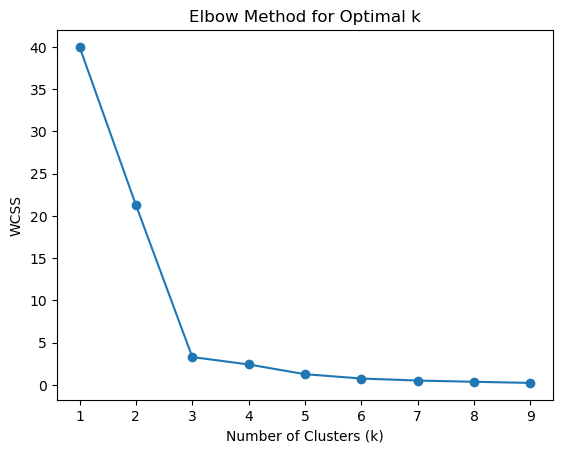

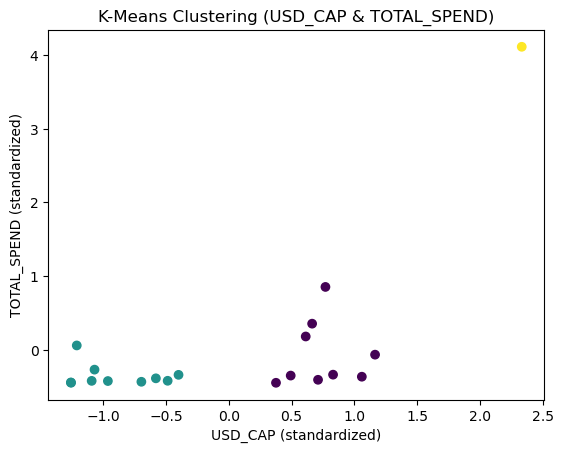

In [41]:
# Select relevant features for clustering
X = top_and_bottom_countries[['USD_CAP', 'TOTAL_SPEND']]

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Determine the optimal number of clusters using the Elbow Method
wcss = []
for k in range(1, 10): # 31 countries in total
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Create a DataFrame for WCSS values and print
#wcss_df = pd.DataFrame({'Number of Clusters': range(1, 10), 'WCSS': wcss})
#print(wcss_df)

# Plot the WCSS to find the elbow
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

# Step 3: Fit K-Means with the chosen number of clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
top_and_bottom_countries['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Interpret and visualize
# Get cluster centroids
centroids = kmeans.cluster_centers_

# Plot clusters in 2D
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=top_and_bottom_countries['Cluster'], cmap='viridis', marker='o')
plt.xlabel('USD_CAP (standardized)')
plt.ylabel('TOTAL_SPEND (standardized)')
plt.title('K-Means Clustering (USD_CAP & TOTAL_SPEND)')
#plt.legend()
plt.show()

In [42]:
# Add cluster labels to the DataFrame
top_and_bottom_countries['Cluster'] = kmeans.labels_
top_and_bottom_countries

LOCATION    TIME  PC_HEALTHXP  PC_GDP   USD_CAP  TOTAL_SPEND  Cluster
0      USA  2009.5      12.1171  1.9084  937.8955   288954.418        2
1      CAN  2009.5      17.9715  1.7740  720.3611    24445.745        0
2      CHE  2009.5      12.2824  1.3064  700.7456     5508.028        0
3      GRC  2009.5      26.7591  2.3890  658.0759     7266.228        0
4      JPN  2009.5      19.6365  1.8187  646.7647    82636.276        0
5      IRL  2009.5      15.1280  1.4058  635.7886     2858.381        0
6      DEU  2009.5      14.7916  1.5719  627.0213    51073.068        0
7      FRA  2009.5      16.3773  1.7227  617.5241    40066.831        0
8      BEL  2009.5      15.6147  1.5132  595.2560     6477.548        0
9      LUX  2009.5       9.4886  0.6326  573.4413      290.057        0
0      LVA  2009.5      24.8619  1.4204  269.1964      566.278        1
1      EST  2009.5      20.6810  1.1794  269.5759      358.804        1
2      MEX  2009.5      31.2677  1.8379  277.9795    32368.577        1
3      ISR  2009.5      13.2833  0.9560  300.1000     1933.890        1
4      POL  2009.5      24.8208  1.5318  304.3207    11590.672        1
5      DNK  2009.5       7.8688  0.7764  324.1352     1793.822        1
6      LTU  2009.5      28.4296  1.7774  373.8094     1157.229        1
7      CZE  2009.5      21.1823  1.4421  395.3186     4118.590        1
8      NOR  2009.5       8.1492  0.6992  412.7879     2013.520        1
9      NLD  2009.5       9.6332  0.9651  428.9097     7109.820        1

In [43]:
print(top_and_bottom_countries.groupby('Cluster')['LOCATION'].count())

Cluster
0     9
1    10
2     1
Name: LOCATION, dtype: int64


Visualizations of Clustering

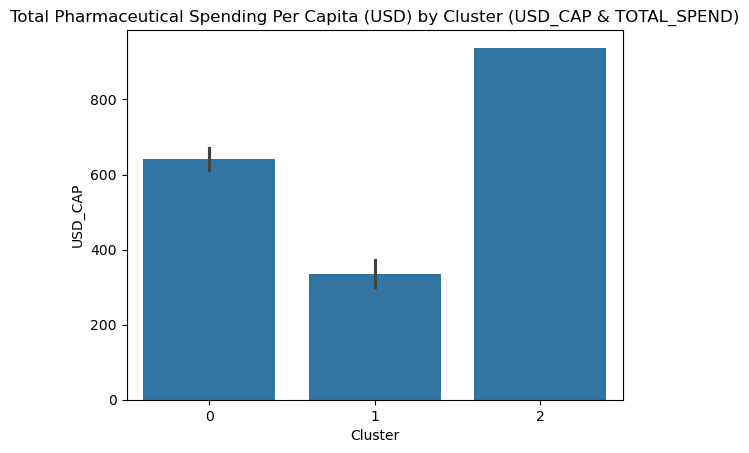

In [45]:
# Bar plot of USD_CAP by cluster
sns.barplot(x='Cluster', y='USD_CAP', data=top_and_bottom_countries)
plt.title('Total Pharmaceutical Spending Per Capita (USD) by Cluster (USD_CAP & TOTAL_SPEND)')
plt.show()

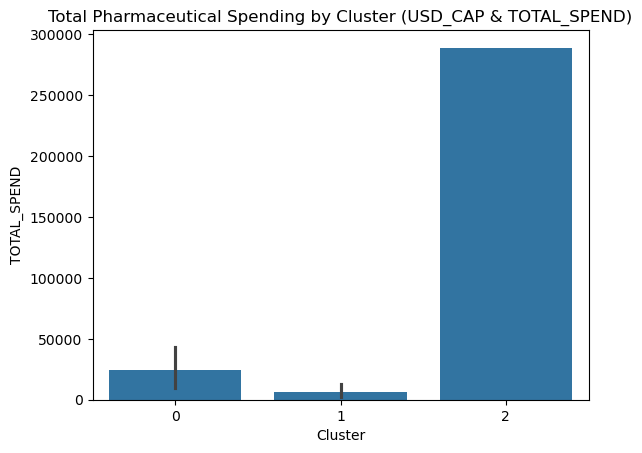

In [46]:
# Bar plot of TOTAL_SPEND by cluster
sns.barplot(x='Cluster', y='TOTAL_SPEND', data=top_and_bottom_countries)
plt.title('Total Pharmaceutical Spending by Cluster (USD_CAP & TOTAL_SPEND)')
plt.show()

From these 2 bar plots, we can make these observations:

Cluster 0 & 2: High spending countries <br>
Cluster 1: Bottom spending countries

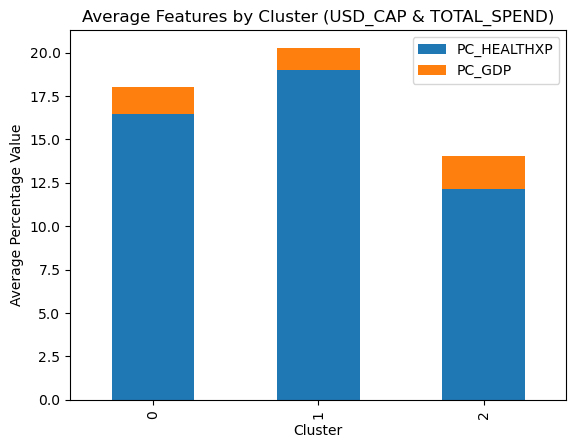

In [47]:
# Group by cluster and calculate the average of the features
avg_features_by_cluster = top_and_bottom_countries.groupby('Cluster')[['PC_HEALTHXP', 'PC_GDP']].mean().reset_index()

# Create a bar plot of the average of PC_HEALTHXP, PC_GDP by Cluster
avg_features_by_cluster.plot(x='Cluster', kind='bar', stacked=True)
plt.title('Average Features by Cluster (USD_CAP & TOTAL_SPEND)')
plt.ylabel('Average Percentage Value')
plt.show()

Interestingly in this stacked plot despite showing high spending, countries in cluster 0 and 2 spend less in pharmaceuticals in terms of percentage of healthcare expenditure. The countries in cluster 0 despite showing low spending, actually spend more in terms of percentage of healthcare expendtiture.

In [44]:
# Sort by cluster to group countries by cluster
country_clusters = top_and_bottom_countries.sort_values(by='Cluster')

# Create a dictionary grouping countries by cluster
cluster_groups = country_clusters.groupby('Cluster')['LOCATION'].apply(list)

# Print the grouped clusters
for cluster, countries in cluster_groups.items():
    print(f"Cluster {cluster}: {', '.join(countries)}")

Cluster 0: LUX, CAN, CHE, GRC, JPN, IRL, DEU, FRA, BEL
Cluster 1: CZE, LTU, DNK, POL, NLD, MEX, EST, LVA, NOR, ISR
Cluster 2: USA


From clustering these 20 countries, they were categorized into 3 clusters. Cluster 0 confirms the top 10 spending countries ranked by average spend per capita. Cluster 1 confirms the bottom 10 spending countries ranked by average spend per capita. Cluster 3 contains only one country (USA), which according to average spend per capita is considered a top spending country. As shown on the cluster graph, USA is an outlier in terms of spending per capita and total spending therefore it's in a category of its own.